In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [2]:
import os
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Chapter 9. Hierarchical Models
- Grid approximation is not included here.
    - Should be done; it is really pedagogical.
- A single coin form a single mint 
- Multiple coins from a single mint
- Therapeutic touch
- Extending the Hierarchy: Subjects within Categories
    - Baseball batting abilities by position

##  Ch.9.1. A single coin from a single mint

- Likelihood
$$
    y_i \sim \mathrm{Bernoulli}(\theta)
$$
- Prior
$$
    \theta \sim \mathrm{Beta}(a,b)
$$
- Given the mode and concentration, $(\omega, \kappa)$,
\begin{align}
    a &= \omega (\kappa - 2) + 1 \\
    b &= (1 - \omega) (\kappa - 2) + 1
\end{align}
- Prior in $(\omega, \kappa)$:
$$
    \theta \sim \mathrm{Beta}\big(\omega (\kappa - 2) + 1, (1 - \omega) (\kappa - 2) + 1 \big)
$$

- The sample value of $\theta$ depends on $\omega$, which specifies the peak of Beta distribution. 
    - Let's define a prior on $\omega$:
$$
    \omega \sim \mathrm{Beta}(A_\omega, B_\omega)
$$
- The magnitue of $\kappa$ is an expression of our prior certainty regarding the depndence of $\theta$ on $\omega$. For simplicity, we treat $\kappa$ as a constant $K$.

- Givn an observation of 9 heads and 3 tails, the prior and likelihood are:
\begin{align}
    p(\omega, \theta) & = p(\omega) p(\theta | \omega) \\
                        &= \mathrm{Beta}(\omega|2,2) 
                          \mathrm{Beta}(\theta| \omega  (K - 2) + 1, (1-\omega)  (K - 2) + 1) \\
    p(\{y_i\} | \theta) &= \theta^9 (1-\theta)^3
\end{align}
- Posterior Distribution:
\begin{align}
    p(\omega, \theta| Y) & = {p(Y|\omega,\theta)p(\omega, \theta)}\big/{p(Y)} \\
                         & = {p(Y|\theta)p(\theta|\omega)p(\omega)}\bigg/{\iint_{\omega,\theta}p(Y|\theta)p(\theta|\omega)p(\omega) d\omega d\theta} 
\end{align}


### Data

In [3]:
# our example data: 9 Heads, 3 Tails
data = jnp.array([1.]*9 + [0.]*3); data

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32)

### Model

In [4]:
def model_single_coin(y=None):
    Aw, Bw = 2, 2
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    K = 100
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    theta = numpyro.sample('theta', dist.Beta(a, b))
    with numpyro.plate(f'N={len(y)}', size=len(y) if y is not None else 1):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)

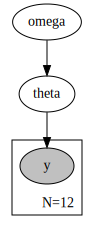

In [6]:
numpyro.render_model(model_single_coin, model_args=(data,))

#### Prior Predictive Check

In [7]:
predictive = Predictive(model_single_coin, num_samples=10000)
samples_pred = predictive(jax.random.PRNGKey(0), dict(y=None))
samples_pred

{'omega': DeviceArray([0.3091138 , 0.44299403, 0.51124775, ..., 0.258861  ,
              0.43504274, 0.29730937], dtype=float32),
 'theta': DeviceArray([0.2834984 , 0.40018925, 0.4711232 , ..., 0.28952098,
              0.5468774 , 0.34777248], dtype=float32),
 'y': {'y': None}}

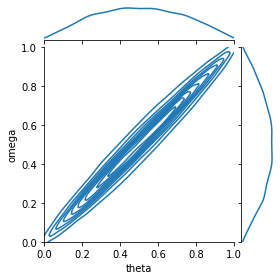

In [8]:
g = sns.jointplot(data=samples_pred, 
                  y='omega', x='theta', kind='kde', 
                  xlim=[0,1], ylim=[0,1], height=4);

#### MCMC Inference

In [9]:
def gomcmc(model, data_dict, num_samples=5000):
    rng_key = jax.random.PRNGKey(0)
    # run MCMC
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=1,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, **data_dict)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc

In [10]:
data_dict=dict(y=data)
mcmc = gomcmc(model_single_coin, data_dict)

sample: 100%|██████████| 6000/6000 [00:07<00:00, 851.57it/s, 15 steps of size 3.05e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     omega      0.69      0.12      0.70      0.51      0.88    945.40      1.00
     theta      0.69      0.11      0.70      0.51      0.87    903.61      1.00

Number of divergences: 0


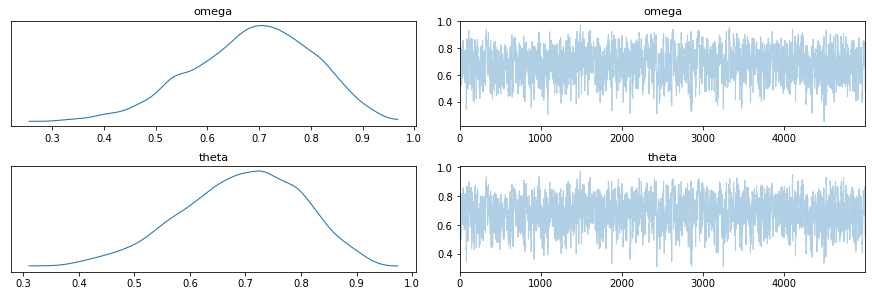

In [11]:
import arviz
arviz.plot_trace(mcmc.get_samples());

In [12]:
samples = pd.DataFrame(mcmc.get_samples())
samples.head(3)

,omega,theta
0,0.525938,0.599643
1,0.658505,0.577623
2,0.623668,0.674670


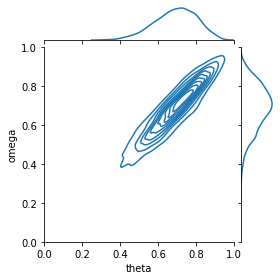

In [13]:
g = sns.jointplot(data=samples, 
                  y='omega', x='theta', kind='kde', 
                  xlim=[0,1], ylim=[0,1], height=4);

- This is MCMC version of the Joint Posterior Distribution $P(\omega, \theta|Y)$
- Compare the plot with the one in Figure 9.2.
- model parameters: $A_w = B_w = 2$, $K=100$, 9 heads, 3 tails.

### Another model with a modified setting

In [14]:
def model_single_coin_2(y=None):
    Aw, Bw = 20, 20  # distribution of the mode location is much narrower
    omega = numpyro.sample('omega', dist.Beta(Aw, Bw))
    K = 6            # concentration of \theta is small == larger uncertainty == wide distr. 
    a = omega * (K - 2) + 1
    b = (1-omega) * (K - 2) + 1
    theta = numpyro.sample('theta', dist.Beta(a, b))
    with numpyro.plate(f'N={len(y)}', size=len(y) if y is not None else 1):
        obs = numpyro.sample('y', dist.Bernoulli(probs=theta), obs=y)

#### Prior Predictive Check

In [15]:
predictive = Predictive(model_single_coin_2, num_samples=11123)
samples_pred = predictive(jax.random.PRNGKey(0), dict(y=None))
samples_pred

{'omega': DeviceArray([0.49186045, 0.5847111 , 0.461427  , ..., 0.58903235,
              0.52969736, 0.4220493 ], dtype=float32),
 'theta': DeviceArray([0.16335125, 0.3890201 , 0.7567967 , ..., 0.41343054,
              0.5853127 , 0.15248545], dtype=float32),
 'y': {'y': None}}

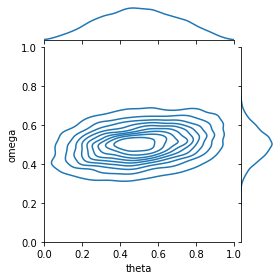

In [16]:
g = sns.jointplot(data=samples_pred, 
                  y='omega', x='theta', kind='kde', 
                  xlim=[0,1], ylim=[0,1], height=4);

#### Inference

In [17]:
data_dict=dict(y=data)
mcmc = gomcmc(model_single_coin_2, data_dict)

sample: 100%|██████████| 6000/6000 [00:07<00:00, 850.41it/s, 3 steps of size 9.20e-01. acc. prob=0.91] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     omega      0.52      0.08      0.52      0.39      0.64   3278.60      1.00
     theta      0.67      0.11      0.68      0.48      0.84   4347.72      1.00

Number of divergences: 0


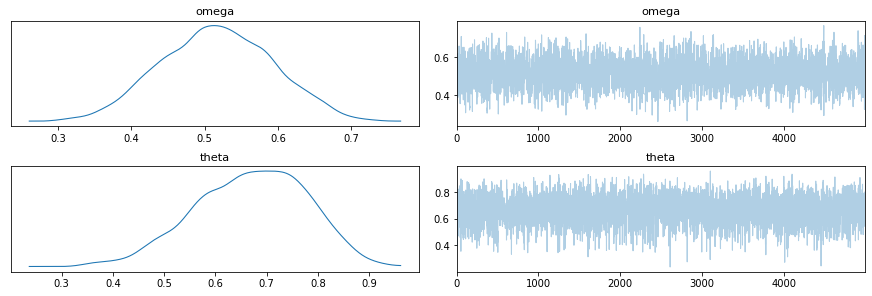

In [18]:
arviz.plot_trace(mcmc.get_samples());

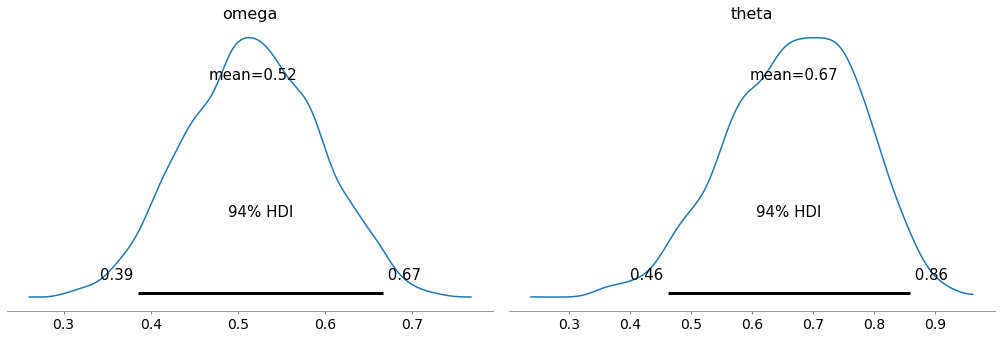

In [19]:
arviz.plot_posterior (mcmc.get_samples());

In [20]:
samples = pd.DataFrame(mcmc.get_samples())
samples.head(3)

,omega,theta
0,0.506910,0.604294
1,0.618734,0.682891
2,0.544753,0.707041


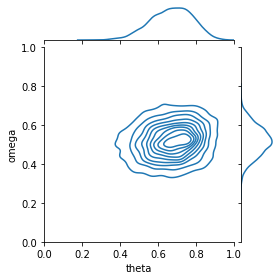

In [21]:
g = sns.jointplot(data=samples, 
                  y='omega', x='theta', kind='kde', 
                  xlim=[0,1], ylim=[0,1], height=4);

- Now compare with Figure 9.3.
- - model parameters: $A_w = B_w = 20$, $K=6$, 9 heads, 3 tails.

---

## Ch. 9.2. Multiple Coins From A Single Mint